# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


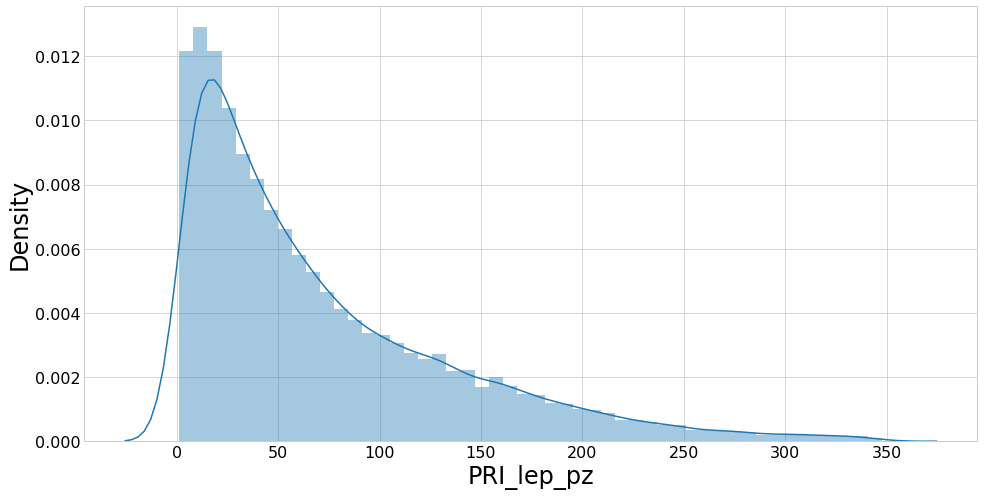

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


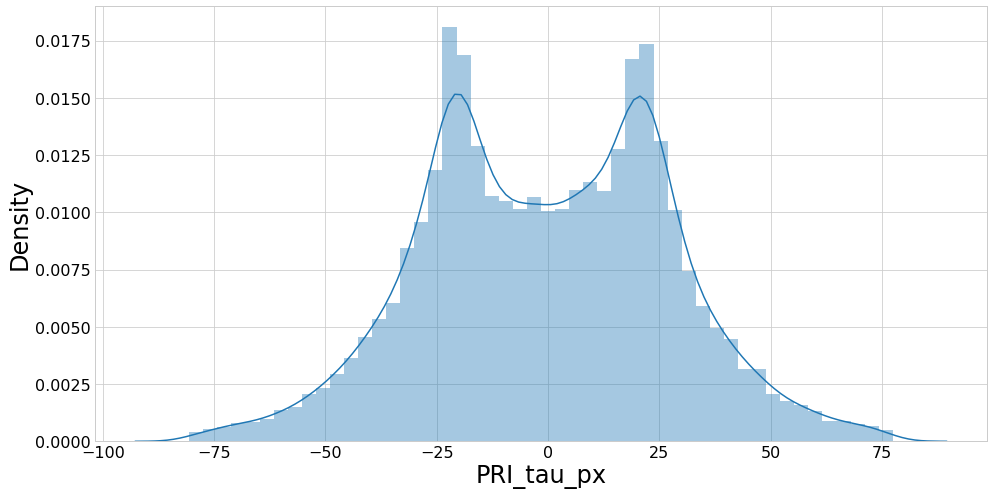

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


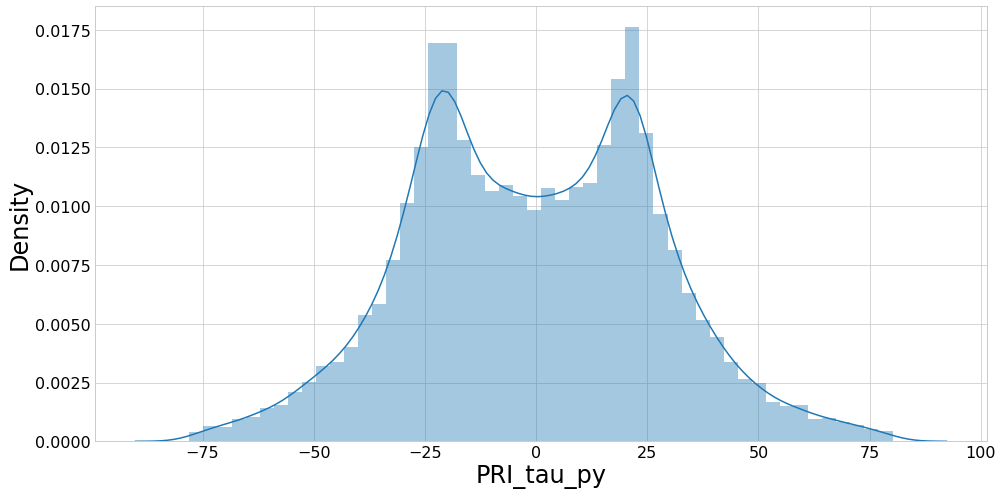

In [6]:
data = pd.DataFrame(input_pipe.inverse_transform(np.array(train_fy.source['fold_0/inputs'])), columns=train_feats)
plot_feat(data, 'PRI_lep_pz')
plot_feat(data, 'PRI_tau_px')
plot_feat(data, 'PRI_tau_py')

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 16.877s 


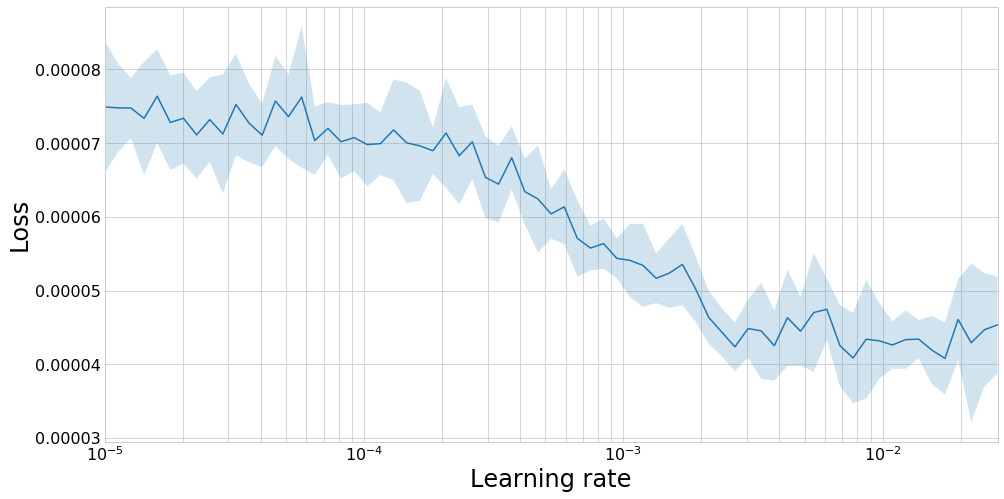

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

1 New best found: 3.963334881317986e-05
2 New best found: 3.7116076779238764e-05
3 New best found: 3.608976993444624e-05
4 New best found: 3.567657736019313e-05
5 New best found: 3.525759834498548e-05
6 New best found: 3.450870943576247e-05
7 New best found: 3.4385263168527576e-05
9 New best found: 3.435452455938593e-05
10 New best found: 3.416766374919399e-05
11 New best found: 3.40424356641893e-05
12 New best found: 3.376045277847829e-05
13 New best found: 3.360549333313779e-05
14 New best found: 3.3467278497021536e-05
15 New best found: 3.345162537339393e-05
23 New best found: 3.310182635846021e-05
25 New best found: 3.297720417392342e-05
27 New best found: 3.2863315023996445e-05
28 New best found: 3.2724910590955585e-05
49 New best found: 3.2702051003494965e-05
50 New best found: 3.269645273230554e-05
52 New best found: 3.264366965451511e-05
53 New best found: 3.252286190

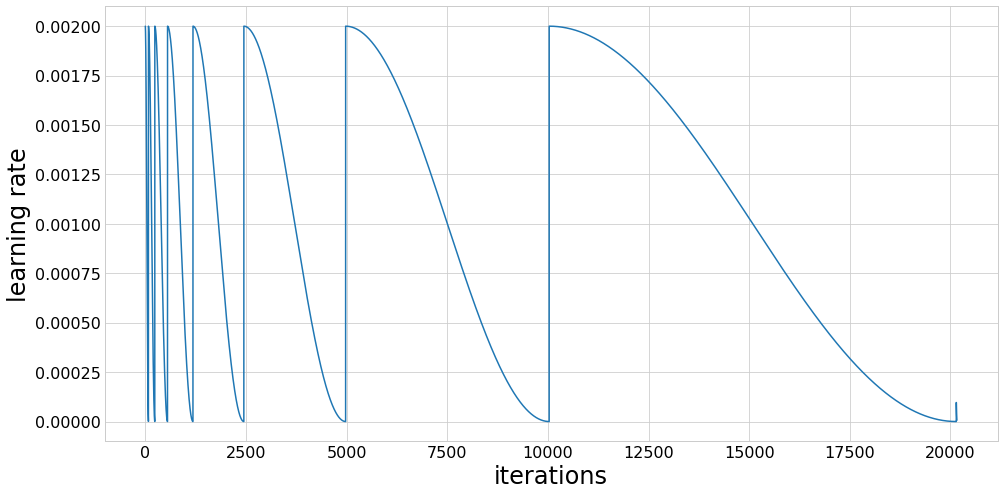

Fold took 248.198s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103641). Check your callbacks.
  % delta_t_median)


1 New best found: 3.784899475659429e-05
2 New best found: 3.586151899320963e-05
3 New best found: 3.5003519728299836e-05
5 New best found: 3.3930849203205106e-05
6 New best found: 3.364545811635158e-05
7 New best found: 3.3457983173250754e-05
10 New best found: 3.344628390213728e-05
11 New best found: 3.325409891092823e-05
12 New best found: 3.292247856506958e-05
13 New best found: 3.2765333006108076e-05
14 New best found: 3.2681065230498054e-05
15 New best found: 3.26338505960762e-05
22 New best found: 3.249539509885106e-05
23 New best found: 3.244437375077746e-05
25 New best found: 3.2251311665268666e-05
28 New best found: 3.2198707351875206e-05
29 New best found: 3.214772632150484e-05
30 New best found: 3.21170264733129e-05
31 New best found: 3.211410820934398e-05
50 New best found: 3.2009080153337755e-05
51 New best found: 3.190511504667577e-05
52 New best found: 3.1851866323568666e-05
58 New best found: 3.1834439046820276e-05
59 New best found: 3.1826354479343546e-05
60 New best f

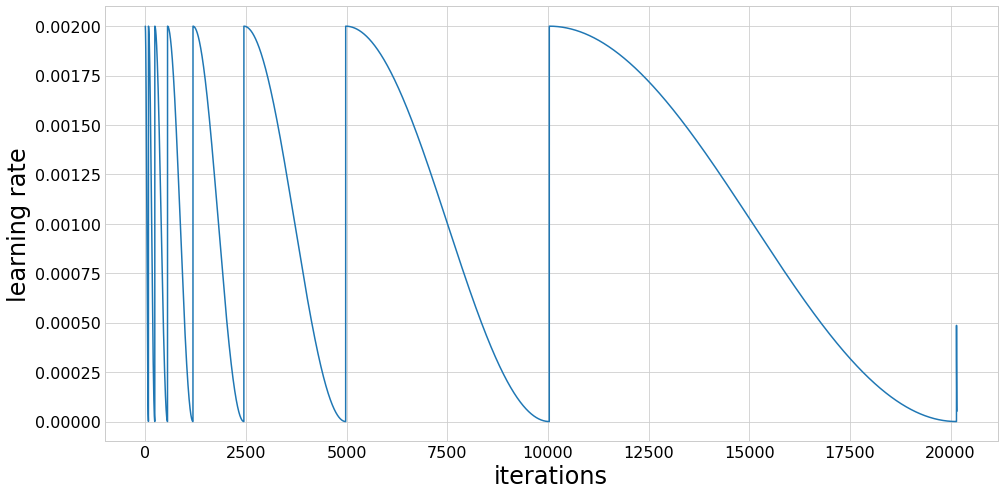

Fold took 252.266s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242819). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121786). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8335509095122996e-05
2 New best found: 3.597671447259435e-05
3 New best found: 3.515924432713116e-05
5 New best found: 3.4253248035042984e-05
6 New best found: 3.366941725997903e-05
7 New best found: 3.3583858651449774e-05
11 New best found: 3.322449686559734e-05
12 New best found: 3.2951499173418315e-05
13 New best found: 3.2841259744553095e-05
14 New best found: 3.2616069290881464e-05
15 New best found: 3.2590857381940196e-05
20 New best found: 3.257949847336015e-05
23 New best found: 3.243578069532443e-05
24 New best found: 3.217712293884777e-05
26 New best found: 3.2049065794421964e-05
27 New best found: 3.195853005060586e-05
28 New best found: 3.190330041742406e-05
29 New best found: 3.1835696371142075e-05
30 New best found: 3.182865292565058e-05
31 New best found: 3.182582013283989e-05
48 New best found: 3.174293550590339e-05
53 New best found: 3.1645833903910354e-05
54 New best found: 3.157738389385331e-05
55 New best found: 3.156997247732886e-05
62 New best 

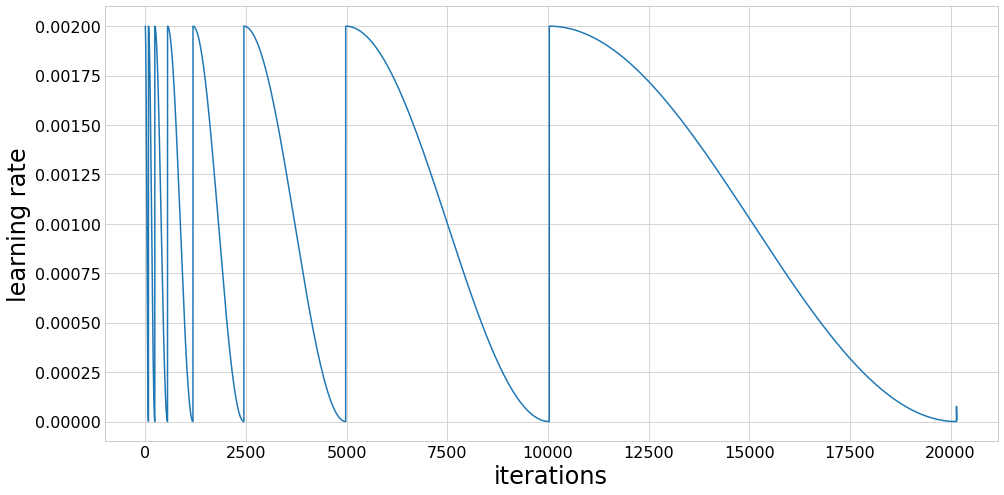

Fold took 254.554s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257483). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129160). Check your callbacks.
  % delta_t_median)


1 New best found: 3.920835502503905e-05
2 New best found: 3.696415745507693e-05
3 New best found: 3.624669704440748e-05
4 New best found: 3.590989222866483e-05
5 New best found: 3.533297731628409e-05
6 New best found: 3.479467620345531e-05
7 New best found: 3.458428001904394e-05
11 New best found: 3.4458024687774016e-05
12 New best found: 3.393529680470238e-05
13 New best found: 3.379130358080147e-05
14 New best found: 3.3653708221390846e-05
21 New best found: 3.356506980126142e-05
23 New best found: 3.33571389928693e-05
24 New best found: 3.3202988939592616e-05
25 New best found: 3.312532414056477e-05
26 New best found: 3.306705714348936e-05
27 New best found: 3.3057455134985505e-05
28 New best found: 3.301158350441255e-05
29 New best found: 3.292679919977673e-05
30 New best found: 3.288710696797352e-05
48 New best found: 3.284026476321742e-05
52 New best found: 3.277514930668985e-05
53 New best found: 3.26838635301101e-05
55 New best found: 3.266768662579125e-05
56 New best found: 3.

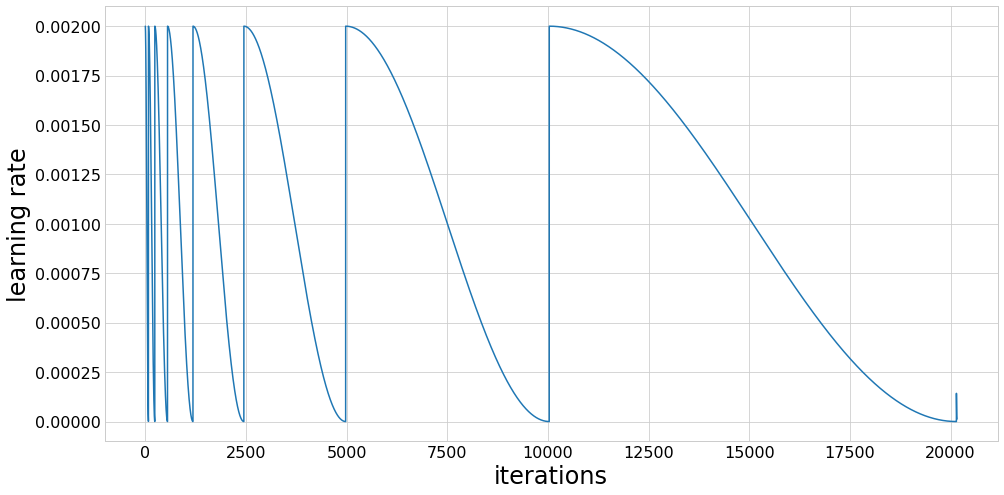

Fold took 262.572s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.282711). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141720). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9274706950527615e-05
2 New best found: 3.570233841164736e-05
3 New best found: 3.5257354949135335e-05
5 New best found: 3.44609831343405e-05
6 New best found: 3.40130615470116e-05
7 New best found: 3.380788576032501e-05
10 New best found: 3.350054887268925e-05
11 New best found: 3.342797007790068e-05
12 New best found: 3.3315544300421604e-05
13 New best found: 3.300934204889927e-05
14 New best found: 3.2938649014977275e-05
15 New best found: 3.2923732641211245e-05
22 New best found: 3.2858561543980616e-05
23 New best found: 3.2789527156273834e-05
24 New best found: 3.269383150181966e-05
26 New best found: 3.2513747735356446e-05
27 New best found: 3.250406875449698e-05
28 New best found: 3.243237199203577e-05
29 New best found: 3.2362821802962574e-05
30 New best found: 3.2347184618993196e-05
49 New best found: 3.2301279970852194e-05
51 New best found: 3.2236979799927215e-05
53 New best found: 3.2130403285555076e-05
54 New best found: 3.2083571124530865e-05
55 New bes

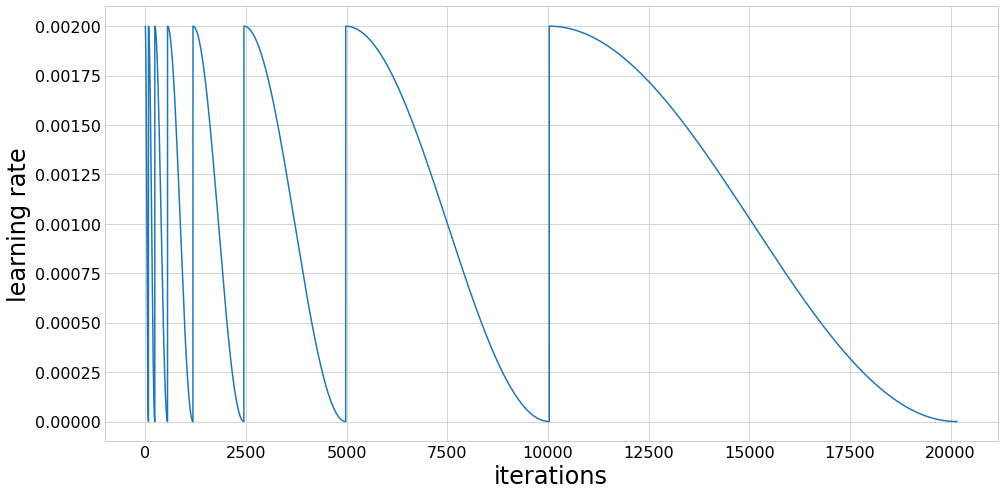

Fold took 268.490s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.297512). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149172). Check your callbacks.
  % delta_t_median)


1 New best found: 3.942990579671459e-05
2 New best found: 3.697761900402838e-05
3 New best found: 3.605845863785362e-05
4 New best found: 3.5849382862215864e-05
5 New best found: 3.5322883194021415e-05
6 New best found: 3.4548161351995074e-05
7 New best found: 3.442369754047831e-05
10 New best found: 3.4286025038454684e-05
11 New best found: 3.395779293205124e-05
12 New best found: 3.3473389473510906e-05
13 New best found: 3.345926893380238e-05
14 New best found: 3.329645356279798e-05
15 New best found: 3.32826673402451e-05
22 New best found: 3.3282242016866804e-05
24 New best found: 3.29805583533016e-05
27 New best found: 3.286821145156864e-05
28 New best found: 3.275770375184948e-05
30 New best found: 3.2710994943045076e-05
31 New best found: 3.270888840925181e-05
45 New best found: 3.259913704969222e-05
48 New best found: 3.259624701749999e-05
50 New best found: 3.255941865791101e-05
51 New best found: 3.250591613323195e-05
52 New best found: 3.2395381420792544e-05
54 New best found

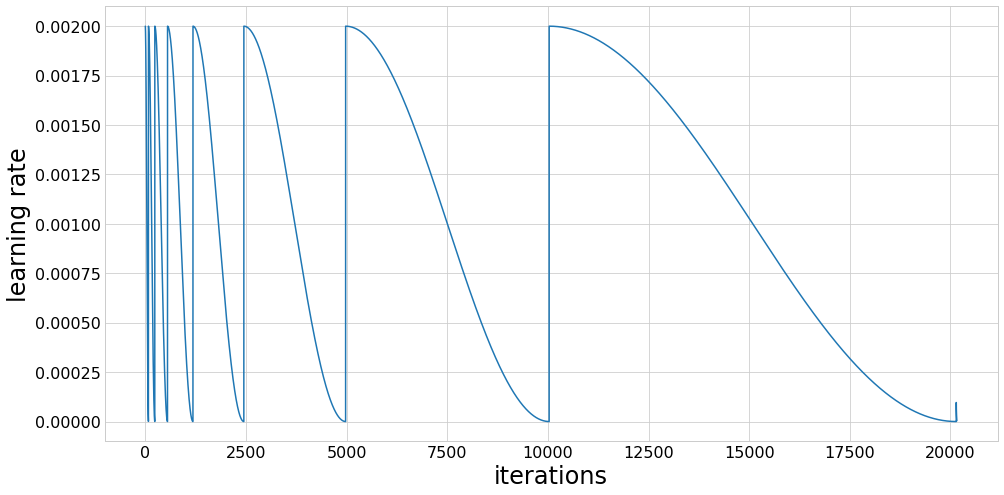

Fold took 281.146s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.321332). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161034). Check your callbacks.
  % delta_t_median)


1 New best found: 3.815790236537133e-05
2 New best found: 3.672799278370488e-05
3 New best found: 3.518008279871098e-05
4 New best found: 3.4897761040067365e-05
5 New best found: 3.417777347782932e-05
6 New best found: 3.3786143028424585e-05
7 New best found: 3.359719283799614e-05
10 New best found: 3.3511101107311656e-05
11 New best found: 3.3494687465023915e-05
12 New best found: 3.304277138101258e-05
13 New best found: 3.2673504354259315e-05
14 New best found: 3.259026773859345e-05
15 New best found: 3.2566464976067286e-05
23 New best found: 3.254342273811327e-05
24 New best found: 3.237557253917033e-05
25 New best found: 3.225009805436492e-05
26 New best found: 3.208631374887133e-05
28 New best found: 3.205068642029789e-05
29 New best found: 3.197423499000983e-05
50 New best found: 3.189988942591974e-05
53 New best found: 3.1803344169507754e-05
54 New best found: 3.17926464315146e-05
55 New best found: 3.1748957514899185e-05
56 New best found: 3.1679840592419055e-05
58 New best fou

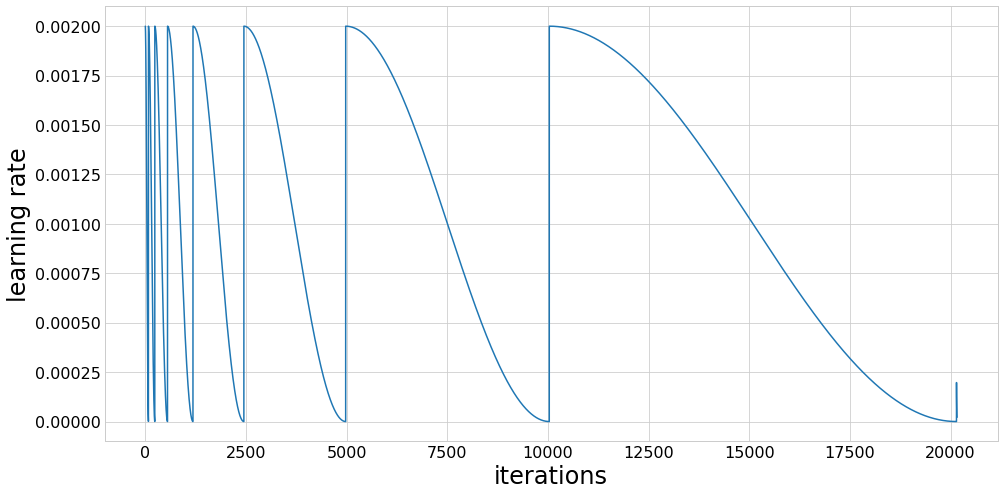

Fold took 277.881s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.350544). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175660). Check your callbacks.
  % delta_t_median)


1 New best found: 3.890887780565532e-05
2 New best found: 3.752384858978958e-05
3 New best found: 3.621215369098078e-05
5 New best found: 3.496652811831926e-05
6 New best found: 3.4693860488149235e-05
7 New best found: 3.4471212033701383e-05
10 New best found: 3.4430981591078074e-05
11 New best found: 3.423790473353306e-05
12 New best found: 3.408478388544503e-05
13 New best found: 3.362687013523293e-05
14 New best found: 3.346773614994583e-05
23 New best found: 3.314040692764874e-05
26 New best found: 3.310535299473646e-05
27 New best found: 3.3008638628458316e-05
28 New best found: 3.2898062718420195e-05
29 New best found: 3.285176260576439e-05
31 New best found: 3.284736414735143e-05
48 New best found: 3.2735785991527144e-05
49 New best found: 3.26905700097974e-05
50 New best found: 3.2591919989991225e-05
51 New best found: 3.2570180324642745e-05
53 New best found: 3.256312239221551e-05
54 New best found: 3.252376788229046e-05
56 New best found: 3.248723506115563e-05
57 New best fou

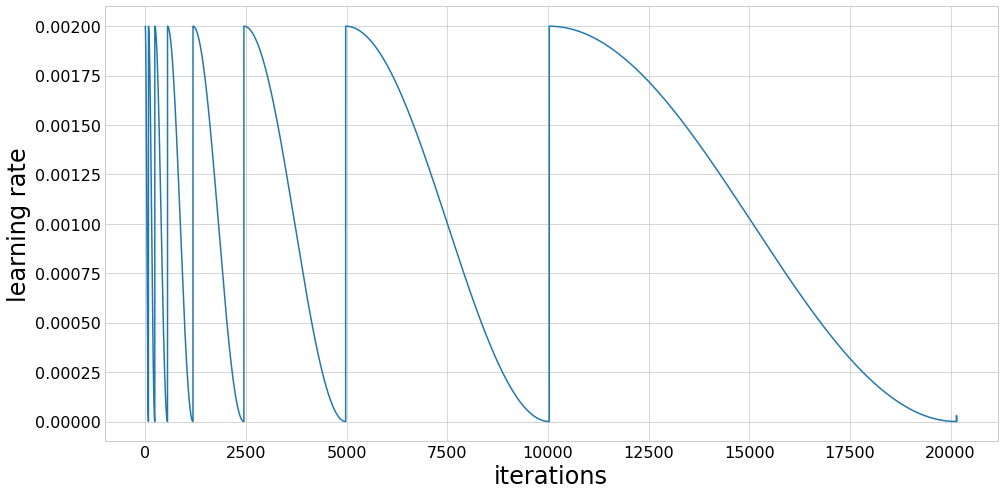

Fold took 286.991s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.375649). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188253). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8734685065804654e-05
2 New best found: 3.629045677713731e-05
3 New best found: 3.493554070490847e-05
4 New best found: 3.4579769653404596e-05
6 New best found: 3.379773959939339e-05
7 New best found: 3.35063910497751e-05
9 New best found: 3.346121538734688e-05
10 New best found: 3.334049060830582e-05
11 New best found: 3.328234270951799e-05
12 New best found: 3.291527450412338e-05
13 New best found: 3.281259755143331e-05
14 New best found: 3.274011770091161e-05
15 New best found: 3.2699072562775185e-05
22 New best found: 3.265493231041753e-05
24 New best found: 3.22960665915503e-05
25 New best found: 3.223645545873284e-05
26 New best found: 3.216270831417388e-05
27 New best found: 3.2155602141579477e-05
28 New best found: 3.202495543867445e-05
29 New best found: 3.197722951428886e-05
30 New best found: 3.196922533031822e-05
31 New best found: 3.19681303082124e-05
49 New best found: 3.19076161583533e-05
51 New best found: 3.1797293408870477e-05
52 New best found: 3.1

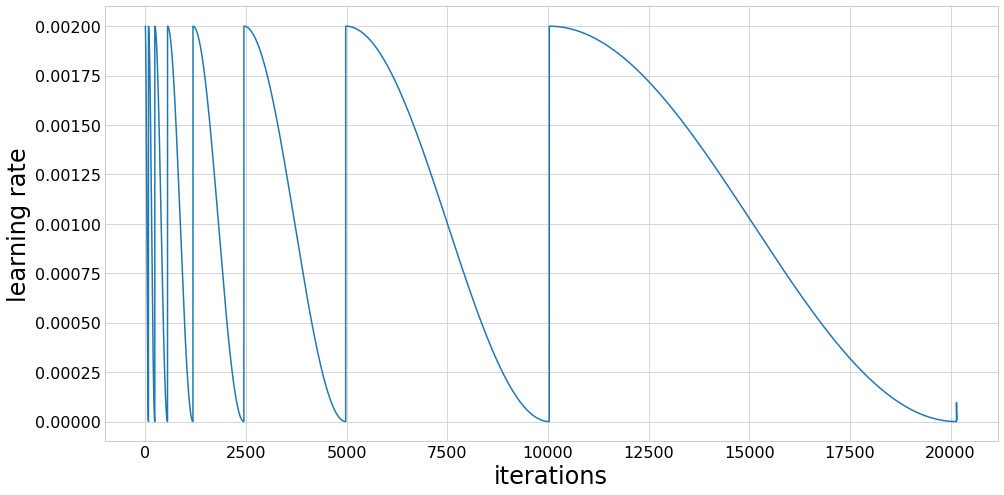

Fold took 292.029s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.393378). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197117). Check your callbacks.
  % delta_t_median)


1 New best found: 4.0068850983516316e-05
2 New best found: 3.692135863966541e-05
3 New best found: 3.6196578056842556e-05
5 New best found: 3.574139566189842e-05
6 New best found: 3.514504311169731e-05
7 New best found: 3.4914816096716096e-05
11 New best found: 3.4781915062922053e-05
12 New best found: 3.457199703261722e-05
13 New best found: 3.426643744314788e-05
14 New best found: 3.409102818259271e-05
15 New best found: 3.4033547833678315e-05
22 New best found: 3.403324262762908e-05
23 New best found: 3.400694457668578e-05
24 New best found: 3.3840851378045044e-05
25 New best found: 3.3727260582963936e-05
26 New best found: 3.360896331432741e-05
27 New best found: 3.3517472316452765e-05
28 New best found: 3.3516178109857716e-05
29 New best found: 3.3488376589957625e-05
30 New best found: 3.346878005831968e-05
52 New best found: 3.329791071737418e-05
54 New best found: 3.310847566463053e-05
60 New best found: 3.3106499504356176e-05
61 New best found: 3.309229211736238e-05
62 New best

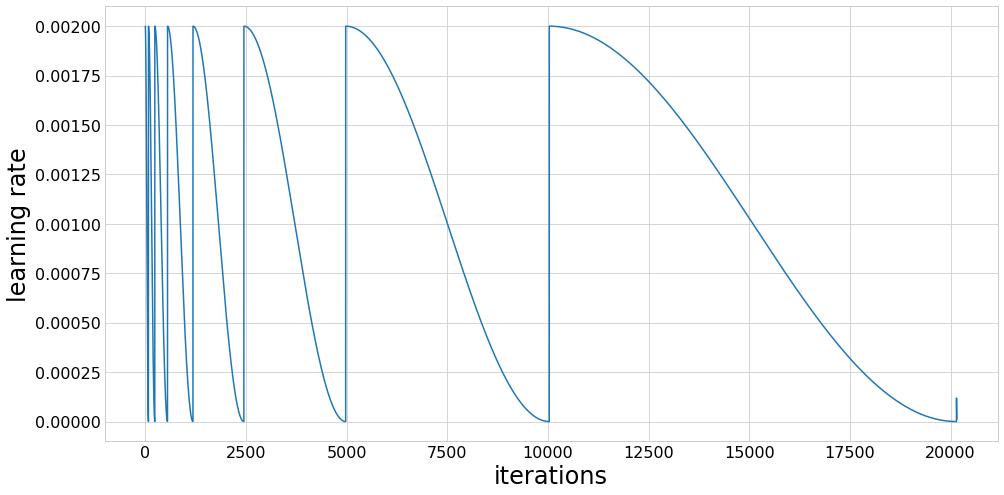

Fold took 296.351s


______________________________________
Training finished
Cross-validation took 2723.316s 


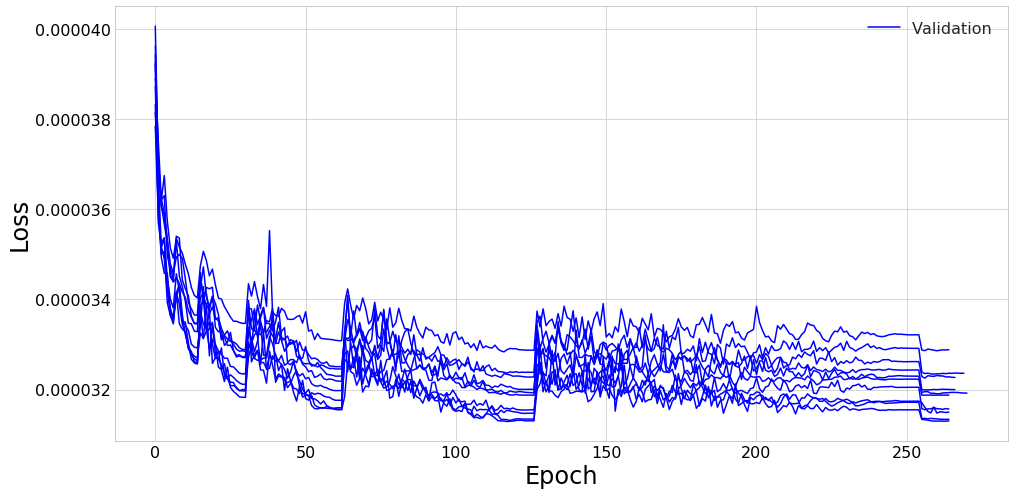

Mean loss = 3.19e-05 +- 2e-07
Mean wAUC = 0.0637 +- 0.0006
Mean AUC = 0.0993 +- 0.0007
Mean AMS = 3.82 +- 0.05
Mean cut = 0.953 +- 0.009
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [10]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [11]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 8 with loss = 3.1289174266104095e-05
Model 1 is 2 with loss = 3.131381878969793e-05
Model 2 is 1 with loss = 3.1455026097549024e-05
Model 3 is 6 with loss = 3.1530690095514355e-05
Model 4 is 4 with loss = 3.187506409158232e-05
Model 5 is 5 with loss = 3.1904513551853595e-05
Model 6 is 7 with loss = 3.199084426891233e-05
Model 7 is 3 with loss = 3.225302003120305e-05
Model 8 is 0 with loss = 3.234214105442136e-05
Model 9 is 9 with loss = 3.283566343015991e-05


## Response on validation data without TTA

In [12]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [13]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.001811508384346962s per sample

Predicting fold 2 out of 10
Prediction took 0.00040754646249115464s per sample

Predicting fold 3 out of 10
Prediction took 0.00040628344267606737s per sample

Predicting fold 4 out of 10
Prediction took 0.0004100535910576582s per sample

Predicting fold 5 out of 10
Prediction took 0.00038716114163398743s per sample

Predicting fold 6 out of 10
Prediction took 0.00039513590820133685s per sample

Predicting fold 7 out of 10
Prediction took 0.00039823523834347726s per sample

Predicting fold 8 out of 10
Prediction took 0.0003878726452589035s per sample

Predicting fold 9 out of 10
Prediction took 0.0003957494147121906s per sample

Predicting fold 10 out of 10
Prediction took 0.00039297412559390066s per sample



In [14]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9028215887972789, weighted 0.9355115823238298


In [15]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.9178719798578086, 0.96063626)

In [16]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9630751288495958, corresponds to calc_ams of 3.851982145186802
CPU times: user 2.62 s, sys: 10.6 s, total: 13.2 s
Wall time: 4min 1s


(4.0, 0.96)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

## Response on validation data with TTA

In [17]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [18]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.006606218818575144s per sample

Predicting fold 2 out of 10
Prediction took 0.006637984815612436s per sample

Predicting fold 3 out of 10
Prediction took 0.006589621816575527s per sample

Predicting fold 4 out of 10
Prediction took 0.006577536857500672s per sample

Predicting fold 5 out of 10
Prediction took 0.006575836690142751s per sample

Predicting fold 6 out of 10
Prediction took 0.006646466800197959s per sample

Predicting fold 7 out of 10
Prediction took 0.0065734803095459935s per sample

Predicting fold 8 out of 10
Prediction took 0.006586190660297871s per sample

Predicting fold 9 out of 10
Prediction took 0.006627771515771747s per sample

Predicting fold 10 out of 10
Prediction took 0.006641475110128522s per sample



In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9029166178881602, weighted 0.9356035016861768


In [20]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.949343440909266, 0.96455646)

In [21]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9636899979086593, corresponds to calc_ams of 3.9030094665015302
CPU times: user 2.69 s, sys: 10.6 s, total: 13.3 s
Wall time: 3min 59s


(4.0, 0.96)

Adding test-time augmentation provides further benefits: overall AMS 3.90->3.97, AMS corresponding to mean cut 3.89->3.91.

# Test scoring - Without TTA

In [22]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [23]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00039795627654953434s per sample

Predicting fold 2 out of 10
Prediction took 0.0003967329126867381s per sample

Predicting fold 3 out of 10
Prediction took 0.0003933367338708856s per sample

Predicting fold 4 out of 10
Prediction took 0.0004111982677470554s per sample

Predicting fold 5 out of 10
Prediction took 0.0003955078710886565s per sample

Predicting fold 6 out of 10
Prediction took 0.0003927569316869432s per sample

Predicting fold 7 out of 10
Prediction took 0.0003988695980472998s per sample

Predicting fold 8 out of 10
Prediction took 0.0003978938032280315s per sample

Predicting fold 9 out of 10
Prediction took 0.00039313496341082183s per sample

Predicting fold 10 out of 10
Prediction took 0.00039401595931161533s per sample

CPU times: user 3min 57s, sys: 5.86 s, total: 4min 3s
Wall time: 3min 38s


In [24]:
score_test_data(test_fy.source, 0.9630751288495958)

Public:Private AMS: 3.6253900595022355 : 3.728483773284047


(3.6253900595022355, 3.728483773284047)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Test scoring - With TTA

In [25]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0064307584132999186s per sample

Predicting fold 2 out of 10
Prediction took 0.00642241785695607s per sample

Predicting fold 3 out of 10
Prediction took 0.0064303677676414905s per sample

Predicting fold 4 out of 10
Prediction took 0.006430967394499616s per sample

Predicting fold 5 out of 10
Prediction took 0.0064127328449013555s per sample

Predicting fold 6 out of 10
Prediction took 0.006438148445873098s per sample

Predicting fold 7 out of 10
Prediction took 0.006421948425268585s per sample

Predicting fold 8 out of 10
Prediction took 0.006421329135921868s per sample

Predicting fold 9 out of 10


In [28]:
score_test_data(test_fy.source, 0.9636899979086593)

Public:Private AMS: 3.5917745504484455 : 3.732004251456598


(3.5917745504484455, 3.732004251456598)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)